# MFCC-based CNN Model for Speech Emotion Recognition

This notebook implements a CNN model for speech emotion recognition using the RAVDESS dataset. The model aims to achieve 85.82% accuracy using MFCC features.

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Preprocessing

In [3]:
def extract_prosodic_features(file_path):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, duration=3)
        
        # Ensure consistent length
        if len(y) < sr * 3:
            y = np.pad(y, (0, sr * 3 - len(y)))
        else:
            y = y[:sr * 3]
        
        # 1. Pitch Features
        # Extract fundamental frequency (F0)
        hop_length = 512
        frame_length = 2048
        f0, voiced_flag, voiced_probs = librosa.pyin(
            y, 
            fmin=librosa.note_to_hz('C2'), 
            fmax=librosa.note_to_hz('C7'),
            sr=sr,
            hop_length=hop_length
        )
        f0 = np.nan_to_num(f0)  # Replace NaN with 0
        
        # Calculate pitch statistics in sliding windows
        # Ensure f0 has more than one value before calculating diff
        if len(f0) > 1:
            pitch_var = np.abs(np.diff(f0, axis=0))
            pitch_var = np.pad(pitch_var, (0, 1), mode='edge')  # Pad to match original length
        else:
            pitch_var = np.zeros_like(f0)
        
        # 2. Stress/Intensity Features
        # Root Mean Square Energy
        rms = librosa.feature.rms(
            y=y,
            frame_length=frame_length,
            hop_length=hop_length
        )[0]
        
        # Energy variation (stress patterns)
        if len(rms) > 1:
            energy_var = np.abs(np.diff(rms, axis=0))
            energy_var = np.pad(energy_var, (0, 1), mode='edge')
        else:
            energy_var = np.zeros_like(rms)
        
        # 3. Speech Rate Features
        # Onset strength for rhythm
        onset_env = librosa.onset.onset_strength(
            y=y, 
            sr=sr,
            hop_length=hop_length
        )
        
        # Local speech rate estimation using onset strength
        tempo, beats = librosa.beat.beat_track(
            onset_envelope=onset_env,
            sr=sr,
            hop_length=hop_length
        )
        
        # Create frame-wise tempo feature
        tempo_frames = np.zeros_like(onset_env)
        if len(beats) > 0:
            tempo_frames[beats] = 1.0
        
        # Calculate speech rate variation
        if len(onset_env) > 1:
            rate_var = np.abs(np.diff(onset_env, axis=0))
            rate_var = np.pad(rate_var, (0, 1), mode='edge')
        else:
            rate_var = np.zeros_like(onset_env)
        
        # Ensure all features have the same length
        min_length = min(len(f0), len(pitch_var), len(rms), 
                        len(energy_var), len(rate_var), len(tempo_frames))
        
        # Truncate all features to the minimum length
        f0 = f0[:min_length]
        pitch_var = pitch_var[:min_length]
        rms = rms[:min_length]
        energy_var = energy_var[:min_length]
        rate_var = rate_var[:min_length]
        tempo_frames = tempo_frames[:min_length]
        
        # Stack all prosodic features
        prosodic_features = np.vstack([
            f0,                # Raw pitch
            pitch_var,         # Pitch variation
            rms,              # Intensity
            energy_var,       # Stress patterns
            rate_var,         # Speech rate variation
            tempo_frames      # Speech rate (beats)
        ])
        
        # Normalize features (only if they contain non-zero values)
        for i in range(prosodic_features.shape[0]):
            if np.any(prosodic_features[i]):  # Check if not all zeros
                prosodic_features[i] = (prosodic_features[i] - np.mean(prosodic_features[i])) / (np.std(prosodic_features[i]) + 1e-8)
        
        return prosodic_features
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_ravdess_data(data_path):
    data = []
    for actor in os.listdir(data_path):
        if actor.startswith('Actor'):
            actor_path = os.path.join(data_path, actor)
            for filename in os.listdir(actor_path):
                file_path = os.path.join(actor_path, filename)
                # Parse filename for labels (format: 03-01-01-01-01-01-01.wav)
                parts = filename.split('-')
                emotion = int(parts[2]) - 1  # Convert to 0-based index
                data.append({
                    'path': file_path,
                    'emotion': emotion,
                    'actor': actor
                })
    return pd.DataFrame(data)

def extract_mfcc(file_path, n_mfcc=40):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, duration=3)
        
        # Ensure consistent length
        if len(y) < sr * 3:
            y = np.pad(y, (0, sr * 3 - len(y)))
        else:
            y = y[:sr * 3]
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# Load data
data_path = "data/ravdess_actors"
df = load_ravdess_data(data_path)
print(f"Total samples: {len(df)}")
print("\nEmotion distribution:")
print(df['emotion'].value_counts())

Total samples: 1440

Emotion distribution:
emotion
1    192
2    192
3    192
4    192
6    192
5    192
7    192
0     96
Name: count, dtype: int64


In [4]:
# Extract MFCC and prosodic features for all audio files
print("Extracting MFCC and prosodic features...")
X_mfcc = []
X_prosody = []
y = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    mfcc = extract_mfcc(row['path'])
    prosody = extract_prosodic_features(row['path'])
    
    if mfcc is not None and prosody is not None:
        # Process MFCC features
        mfcc = mfcc.T  # Shape becomes (time_steps, n_mfcc)
        
        # Process prosodic features
        prosody = prosody.T  # Shape becomes (time_steps, n_prosodic_features)
        
        # Ensure same temporal dimension for both features
        min_length = min(mfcc.shape[0], prosody.shape[0])
        mfcc = mfcc[:min_length]
        prosody = prosody[:min_length]
        
        X_mfcc.append(mfcc)
        X_prosody.append(prosody)
        y.append(row['emotion'])

# Convert to numpy arrays
X_mfcc = np.array(X_mfcc)
X_prosody = np.array(X_prosody)
y = np.array(y)

print(f"MFCC features shape: {X_mfcc.shape}")
print(f"Prosodic features shape: {X_prosody.shape}")
print(f"Labels shape: {y.shape}")

# Split the data
X_mfcc_train, X_mfcc_test, X_prosody_train, X_prosody_test, y_train, y_test = train_test_split(
    X_mfcc, X_prosody, y, test_size=0.2, random_state=42
)

# Convert to torch tensors
X_mfcc_train = torch.FloatTensor(X_mfcc_train).transpose(1, 2)
X_mfcc_test = torch.FloatTensor(X_mfcc_test).transpose(1, 2)
X_prosody_train = torch.FloatTensor(X_prosody_train).transpose(1, 2)
X_prosody_test = torch.FloatTensor(X_prosody_test).transpose(1, 2)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

print("\nTraining set shapes:")
print(f"MFCC: {X_mfcc_train.shape}")
print(f"Prosody: {X_prosody_train.shape}")
print(f"Test set shapes:")
print(f"MFCC: {X_mfcc_test.shape}")
print(f"Prosody: {X_prosody_test.shape}")
print(f"Number of training samples: {len(y_train)}")
print(f"Number of test samples: {len(y_test)}")

# Create custom dataset class for multiple inputs
class MultiModalDataset(Dataset):
    def __init__(self, mfcc_features, prosody_features, labels):
        self.mfcc_features = mfcc_features
        self.prosody_features = prosody_features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (self.mfcc_features[idx], self.prosody_features[idx]), self.labels[idx]

# Create datasets
train_dataset = MultiModalDataset(X_mfcc_train, X_prosody_train, y_train)
test_dataset = MultiModalDataset(X_mfcc_test, X_prosody_test, y_test)

Extracting MFCC and prosodic features...


100%|██████████| 1440/1440 [15:44<00:00,  1.52it/s]

MFCC features shape: (1440, 130, 40)
Prosodic features shape: (1440, 130, 6)
Labels shape: (1440,)

Training set shapes:
MFCC: torch.Size([1152, 40, 130])
Prosody: torch.Size([1152, 6, 130])
Test set shapes:
MFCC: torch.Size([288, 40, 130])
Prosody: torch.Size([288, 6, 130])
Number of training samples: 1152
Number of test samples: 288


## Model Architecture
Here's the CNN model architecture that achieves 85.82% accuracy using MFCC features:

In [5]:
class EmotionCRNN(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionCRNN, self).__init__()
        
        # MFCC branch
        self.mfcc_conv1 = nn.Sequential(
            nn.Conv1d(40, 64, kernel_size=3, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.2)
        )
        
        self.mfcc_conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.3)
        )
        
        # Prosody branch
        self.prosody_conv1 = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=3, padding='same'),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=3, padding='same'),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.2)
        )
        
        self.prosody_conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.3)
        )
        
        # Shared layers (128 + 64 = 192 channels after concatenation)
        self.shared_conv = nn.Sequential(
            nn.Conv1d(192, 256, kernel_size=3, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.4)
        )
        
        # Bidirectional LSTM layers
        self.lstm1 = nn.LSTM(256, 128, bidirectional=True, batch_first=True)
        self.lstm_dropout1 = nn.Dropout(0.4)
        self.lstm2 = nn.LSTM(256, 128, bidirectional=True, batch_first=True)
        self.lstm_dropout2 = nn.Dropout(0.4)
        
        # Prosody-aware attention components
        self.prosody_projection = nn.Linear(64, 256)  # Project prosody to match LSTM size
        self.query_transform = nn.Linear(256, 256)
        self.key_transform = nn.Linear(256, 256)
        self.value_transform = nn.Linear(256, 256)
        
        # Attention combination
        self.attention_combine = nn.Sequential(
            nn.Linear(256, 256),
            nn.Sigmoid()
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc_bn = nn.BatchNorm1d(128)
        self.fc_relu = nn.ReLU()
        self.fc_dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def prosody_aware_attention(self, lstm_output, prosody_features):
        # Ensure prosody_features have the same sequence length as lstm_output
        if prosody_features.size(1) != lstm_output.size(1):
            prosody_features = torch.nn.functional.interpolate(
                prosody_features.transpose(1, 2),
                size=lstm_output.size(1),
                mode='linear'
            ).transpose(1, 2)
        
        # Project prosody features to match LSTM dimension
        prosody_proj = self.prosody_projection(prosody_features)
        
        # Compute attention scores using scaled dot-product attention
        queries = self.query_transform(lstm_output)
        keys = self.key_transform(prosody_proj)
        values = self.value_transform(lstm_output)
        
        # Scaled dot-product attention
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        attention_scores = attention_scores / (256 ** 0.5)  # Scale by sqrt(d_k)
        attention_weights = torch.softmax(attention_scores, dim=-1)
        
        # Apply attention weights
        context = torch.matmul(attention_weights, values)
        
        # Gating mechanism
        gate = self.attention_combine(context)
        gated_context = gate * context + (1 - gate) * lstm_output
        
        # Global average pooling
        pooled = torch.mean(gated_context, dim=1)
        
        return pooled, attention_weights
        
    def forward(self, inputs):
        mfcc_input, prosody_input = inputs
        batch_size = mfcc_input.size(0)
        
        # Process MFCC branch
        mfcc = self.mfcc_conv1(mfcc_input)
        mfcc = self.mfcc_conv2(mfcc)
        
        # Process Prosody branch
        prosody = self.prosody_conv1(prosody_input)
        prosody = self.prosody_conv2(prosody)
        
        # Save prosody features for attention
        prosody_features = prosody.transpose(1, 2)
        
        # Concatenate features along the channel dimension
        x = torch.cat([mfcc, prosody], dim=1)
        
        # Shared processing
        x = self.shared_conv(x)
        
        # Prepare for LSTM (B, C, T) -> (B, T, C)
        x = x.transpose(1, 2)
        
        # Bidirectional LSTM layers
        lstm_out1, _ = self.lstm1(x)
        lstm_out1 = self.lstm_dropout1(lstm_out1)
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = self.lstm_dropout2(lstm_out2)
        
        # Apply prosody-aware attention
        attended, _ = self.prosody_aware_attention(lstm_out2, prosody_features)
        
        # Fully connected layers
        x = self.fc1(attended)
        x = self.fc_bn(x)
        x = self.fc_relu(x)
        x = self.fc_dropout(x)
        x = self.fc2(x)
        
        return x

# Create the model instance
model = EmotionCRNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Mixup criterion function
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

print(model)

EmotionCRNN(
  (mfcc_conv1): Sequential(
    (0): Conv1d(40, 64, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (mfcc_conv2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=

## Training Configuration
The model uses the following training parameters:
- Batch size: 16
- Number of epochs: 200
- Learning rate: 0.00005
- Optimizer: RMSprop
- Loss function: CrossEntropyLoss
- Dropout rate: 0.1

In [6]:
# Training parameters
import math

num_epochs = 300
batch_size = 24

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Learning rate scheduler with warmup
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Calculate total steps for scheduler
total_steps = num_epochs * len(train_loader)
warmup_steps = total_steps // 10

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Mixup augmentation function with adaptive alpha
def mixup_data(x, y, epoch, num_epochs, alpha_start=0.2, alpha_end=0.4):
    alpha = alpha_start + (alpha_end - alpha_start) * (epoch / num_epochs)
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x[0].size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = (
        lam * x[0] + (1 - lam) * x[0][index],
        lam * x[1] + (1 - lam) * x[1][index]
    )
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Training loop
train_losses = []
test_accuracies = []
best_accuracy = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    # Training phase
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
        for (mfcc_x, prosody_x), batch_y in pbar:
            mfcc_x = mfcc_x.to(device)
            prosody_x = prosody_x.to(device)
            batch_y = batch_y.to(device)
            
            # Apply mixup with adaptive alpha
            mixed_X, y_a, y_b, lam = mixup_data((mfcc_x, prosody_x), batch_y, epoch, num_epochs)
            
            optimizer.zero_grad()
            outputs = model(mixed_X)
            
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
    
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    val_losses = []
    
    with torch.no_grad():
        for (mfcc_x, prosody_x), batch_y in test_loader:
            mfcc_x = mfcc_x.to(device)
            prosody_x = prosody_x.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model((mfcc_x, prosody_x))
            
            val_loss = criterion(outputs, batch_y)
            val_losses.append(val_loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    train_losses.append(total_loss / len(train_loader))
    
    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict().copy()
        epoch_predictions = all_predictions
        epoch_targets = all_targets
        
        # Save model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': accuracy,
        }, 'best_multimodal_model.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {train_losses[-1]:.4f}')
    print(f'Validation Loss: {np.mean(val_losses):.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Best Accuracy: {best_accuracy:.2f}%')
    print('-' * 50)

# Load best model
model.load_state_dict(best_model_state)
print(f'\nFinal Best Accuracy: {best_accuracy:.2f}%')

Epoch 1/300: 100%|██████████| 48/48 [00:01<00:00, 27.17it/s, loss=2.22]



Epoch [1/300]
Training Loss: 2.1773
Validation Loss: 2.0646
Test Accuracy: 17.01%
Best Accuracy: 17.01%
--------------------------------------------------


Epoch 2/300: 100%|██████████| 48/48 [00:00<00:00, 66.06it/s, loss=2.13]



Epoch [2/300]
Training Loss: 2.1193
Validation Loss: 1.8661
Test Accuracy: 23.26%
Best Accuracy: 23.26%
--------------------------------------------------


Epoch 3/300: 100%|██████████| 48/48 [00:00<00:00, 58.18it/s, loss=1.78]



Epoch [3/300]
Training Loss: 1.9951
Validation Loss: 1.7077
Test Accuracy: 31.60%
Best Accuracy: 31.60%
--------------------------------------------------


Epoch 4/300: 100%|██████████| 48/48 [00:00<00:00, 63.39it/s, loss=1.8] 



Epoch [4/300]
Training Loss: 1.9573
Validation Loss: 1.6234
Test Accuracy: 39.93%
Best Accuracy: 39.93%
--------------------------------------------------


Epoch 5/300: 100%|██████████| 48/48 [00:00<00:00, 59.07it/s, loss=1.91]



Epoch [5/300]
Training Loss: 1.8440
Validation Loss: 1.5254
Test Accuracy: 43.40%
Best Accuracy: 43.40%
--------------------------------------------------


Epoch 6/300: 100%|██████████| 48/48 [00:00<00:00, 66.38it/s, loss=1.64]



Epoch [6/300]
Training Loss: 1.7478
Validation Loss: 1.5460
Test Accuracy: 41.67%
Best Accuracy: 43.40%
--------------------------------------------------


Epoch 7/300: 100%|██████████| 48/48 [00:00<00:00, 63.56it/s, loss=1.61]



Epoch [7/300]
Training Loss: 1.6478
Validation Loss: 1.4094
Test Accuracy: 46.18%
Best Accuracy: 46.18%
--------------------------------------------------


Epoch 8/300: 100%|██████████| 48/48 [00:00<00:00, 65.18it/s, loss=1.65]



Epoch [8/300]
Training Loss: 1.6026
Validation Loss: 1.3151
Test Accuracy: 51.74%
Best Accuracy: 51.74%
--------------------------------------------------


Epoch 9/300: 100%|██████████| 48/48 [00:00<00:00, 64.59it/s, loss=1.98]



Epoch [9/300]
Training Loss: 1.5220
Validation Loss: 1.2964
Test Accuracy: 50.35%
Best Accuracy: 51.74%
--------------------------------------------------


Epoch 10/300: 100%|██████████| 48/48 [00:00<00:00, 62.84it/s, loss=1.42] 



Epoch [10/300]
Training Loss: 1.4574
Validation Loss: 1.1414
Test Accuracy: 51.74%
Best Accuracy: 51.74%
--------------------------------------------------


Epoch 11/300: 100%|██████████| 48/48 [00:00<00:00, 71.81it/s, loss=1.61] 



Epoch [11/300]
Training Loss: 1.3982
Validation Loss: 1.2082
Test Accuracy: 55.21%
Best Accuracy: 55.21%
--------------------------------------------------


Epoch 12/300: 100%|██████████| 48/48 [00:00<00:00, 75.68it/s, loss=1.24] 



Epoch [12/300]
Training Loss: 1.3183
Validation Loss: 1.0869
Test Accuracy: 56.25%
Best Accuracy: 56.25%
--------------------------------------------------


Epoch 13/300: 100%|██████████| 48/48 [00:00<00:00, 69.44it/s, loss=1.41] 



Epoch [13/300]
Training Loss: 1.3095
Validation Loss: 1.2370
Test Accuracy: 54.17%
Best Accuracy: 56.25%
--------------------------------------------------


Epoch 14/300: 100%|██████████| 48/48 [00:00<00:00, 72.54it/s, loss=1.02] 



Epoch [14/300]
Training Loss: 1.2540
Validation Loss: 1.1574
Test Accuracy: 59.03%
Best Accuracy: 59.03%
--------------------------------------------------


Epoch 15/300: 100%|██████████| 48/48 [00:00<00:00, 76.81it/s, loss=1.47] 



Epoch [15/300]
Training Loss: 1.2932
Validation Loss: 1.0964
Test Accuracy: 57.29%
Best Accuracy: 59.03%
--------------------------------------------------


Epoch 16/300: 100%|██████████| 48/48 [00:00<00:00, 70.70it/s, loss=1.18] 



Epoch [16/300]
Training Loss: 1.2008
Validation Loss: 1.0344
Test Accuracy: 60.42%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 17/300: 100%|██████████| 48/48 [00:00<00:00, 73.81it/s, loss=1.2]  



Epoch [17/300]
Training Loss: 1.1232
Validation Loss: 1.2254
Test Accuracy: 57.99%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 18/300: 100%|██████████| 48/48 [00:00<00:00, 76.08it/s, loss=1.62] 



Epoch [18/300]
Training Loss: 1.1504
Validation Loss: 1.2654
Test Accuracy: 53.12%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 19/300: 100%|██████████| 48/48 [00:00<00:00, 68.75it/s, loss=0.766]



Epoch [19/300]
Training Loss: 1.1720
Validation Loss: 1.0888
Test Accuracy: 60.42%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 20/300: 100%|██████████| 48/48 [00:00<00:00, 74.96it/s, loss=0.847]



Epoch [20/300]
Training Loss: 1.1612
Validation Loss: 1.0010
Test Accuracy: 64.58%
Best Accuracy: 64.58%
--------------------------------------------------


Epoch 21/300: 100%|██████████| 48/48 [00:00<00:00, 72.27it/s, loss=0.837]



Epoch [21/300]
Training Loss: 1.0653
Validation Loss: 0.9155
Test Accuracy: 65.62%
Best Accuracy: 65.62%
--------------------------------------------------


Epoch 22/300: 100%|██████████| 48/48 [00:00<00:00, 69.04it/s, loss=1.07] 



Epoch [22/300]
Training Loss: 1.0536
Validation Loss: 1.0669
Test Accuracy: 60.76%
Best Accuracy: 65.62%
--------------------------------------------------


Epoch 23/300: 100%|██████████| 48/48 [00:00<00:00, 73.79it/s, loss=0.891]



Epoch [23/300]
Training Loss: 1.0727
Validation Loss: 1.1397
Test Accuracy: 59.38%
Best Accuracy: 65.62%
--------------------------------------------------


Epoch 24/300: 100%|██████████| 48/48 [00:00<00:00, 74.56it/s, loss=0.756]



Epoch [24/300]
Training Loss: 1.0021
Validation Loss: 1.1722
Test Accuracy: 61.46%
Best Accuracy: 65.62%
--------------------------------------------------


Epoch 25/300: 100%|██████████| 48/48 [00:00<00:00, 70.11it/s, loss=0.566]



Epoch [25/300]
Training Loss: 1.0665
Validation Loss: 1.1805
Test Accuracy: 56.60%
Best Accuracy: 65.62%
--------------------------------------------------


Epoch 26/300: 100%|██████████| 48/48 [00:00<00:00, 73.55it/s, loss=0.569]



Epoch [26/300]
Training Loss: 1.0377
Validation Loss: 1.4522
Test Accuracy: 51.04%
Best Accuracy: 65.62%
--------------------------------------------------


Epoch 27/300: 100%|██████████| 48/48 [00:00<00:00, 74.53it/s, loss=0.535]



Epoch [27/300]
Training Loss: 1.0571
Validation Loss: 1.0684
Test Accuracy: 63.19%
Best Accuracy: 65.62%
--------------------------------------------------


Epoch 28/300: 100%|██████████| 48/48 [00:00<00:00, 70.94it/s, loss=0.578]



Epoch [28/300]
Training Loss: 0.9441
Validation Loss: 1.0448
Test Accuracy: 64.24%
Best Accuracy: 65.62%
--------------------------------------------------


Epoch 29/300: 100%|██████████| 48/48 [00:00<00:00, 66.38it/s, loss=0.643]



Epoch [29/300]
Training Loss: 0.9113
Validation Loss: 0.8690
Test Accuracy: 71.53%
Best Accuracy: 71.53%
--------------------------------------------------


Epoch 30/300: 100%|██████████| 48/48 [00:00<00:00, 73.52it/s, loss=0.919]



Epoch [30/300]
Training Loss: 1.0281
Validation Loss: 1.0867
Test Accuracy: 63.89%
Best Accuracy: 71.53%
--------------------------------------------------


Epoch 31/300: 100%|██████████| 48/48 [00:00<00:00, 74.95it/s, loss=1.79] 



Epoch [31/300]
Training Loss: 1.0548
Validation Loss: 1.4613
Test Accuracy: 55.90%
Best Accuracy: 71.53%
--------------------------------------------------


Epoch 32/300: 100%|██████████| 48/48 [00:00<00:00, 72.51it/s, loss=0.993]



Epoch [32/300]
Training Loss: 1.0922
Validation Loss: 1.1591
Test Accuracy: 62.50%
Best Accuracy: 71.53%
--------------------------------------------------


Epoch 33/300: 100%|██████████| 48/48 [00:00<00:00, 74.99it/s, loss=1.78] 



Epoch [33/300]
Training Loss: 1.0546
Validation Loss: 1.3912
Test Accuracy: 53.82%
Best Accuracy: 71.53%
--------------------------------------------------


Epoch 34/300: 100%|██████████| 48/48 [00:00<00:00, 74.17it/s, loss=1.1]  



Epoch [34/300]
Training Loss: 0.9753
Validation Loss: 1.5664
Test Accuracy: 55.21%
Best Accuracy: 71.53%
--------------------------------------------------


Epoch 35/300: 100%|██████████| 48/48 [00:00<00:00, 66.60it/s, loss=0.794]



Epoch [35/300]
Training Loss: 0.9375
Validation Loss: 0.8986
Test Accuracy: 69.10%
Best Accuracy: 71.53%
--------------------------------------------------


Epoch 36/300: 100%|██████████| 48/48 [00:00<00:00, 65.81it/s, loss=0.854]


Epoch [36/300]
Training Loss: 0.8934
Validation Loss: 1.0213
Test Accuracy: 65.28%
Best Accuracy: 71.53%
--------------------------------------------------


Epoch 37/300: 100%|██████████| 48/48 [00:00<00:00, 68.32it/s, loss=1.09] 



Epoch [37/300]
Training Loss: 0.8212
Validation Loss: 0.9383
Test Accuracy: 67.71%
Best Accuracy: 71.53%
--------------------------------------------------


Epoch 38/300: 100%|██████████| 48/48 [00:00<00:00, 69.05it/s, loss=0.832]



Epoch [38/300]
Training Loss: 0.8594
Validation Loss: 0.9657
Test Accuracy: 70.49%
Best Accuracy: 71.53%
--------------------------------------------------


Epoch 39/300: 100%|██████████| 48/48 [00:00<00:00, 60.54it/s, loss=0.337]



Epoch [39/300]
Training Loss: 0.7662
Validation Loss: 1.0318
Test Accuracy: 64.93%
Best Accuracy: 71.53%
--------------------------------------------------


Epoch 40/300: 100%|██████████| 48/48 [00:00<00:00, 70.02it/s, loss=0.793]



Epoch [40/300]
Training Loss: 0.8759
Validation Loss: 0.9974
Test Accuracy: 69.44%
Best Accuracy: 71.53%
--------------------------------------------------


Epoch 41/300: 100%|██████████| 48/48 [00:00<00:00, 68.82it/s, loss=0.286]



Epoch [41/300]
Training Loss: 0.8687
Validation Loss: 0.8811
Test Accuracy: 72.92%
Best Accuracy: 72.92%
--------------------------------------------------


Epoch 42/300: 100%|██████████| 48/48 [00:00<00:00, 68.12it/s, loss=0.581]



Epoch [42/300]
Training Loss: 0.8102
Validation Loss: 0.8536
Test Accuracy: 72.57%
Best Accuracy: 72.92%
--------------------------------------------------


Epoch 43/300: 100%|██████████| 48/48 [00:00<00:00, 71.20it/s, loss=0.475]



Epoch [43/300]
Training Loss: 0.9319
Validation Loss: 0.9133
Test Accuracy: 73.26%
Best Accuracy: 73.26%
--------------------------------------------------


Epoch 44/300: 100%|██████████| 48/48 [00:00<00:00, 80.75it/s, loss=2.65] 



Epoch [44/300]
Training Loss: 0.8610
Validation Loss: 0.9294
Test Accuracy: 69.44%
Best Accuracy: 73.26%
--------------------------------------------------


Epoch 45/300: 100%|██████████| 48/48 [00:00<00:00, 79.92it/s, loss=0.29] 



Epoch [45/300]
Training Loss: 0.9537
Validation Loss: 0.9117
Test Accuracy: 69.79%
Best Accuracy: 73.26%
--------------------------------------------------


Epoch 46/300: 100%|██████████| 48/48 [00:00<00:00, 74.09it/s, loss=0.412]



Epoch [46/300]
Training Loss: 0.8646
Validation Loss: 0.8581
Test Accuracy: 72.92%
Best Accuracy: 73.26%
--------------------------------------------------


Epoch 47/300: 100%|██████████| 48/48 [00:00<00:00, 78.58it/s, loss=0.477]



Epoch [47/300]
Training Loss: 0.9007
Validation Loss: 0.8829
Test Accuracy: 72.57%
Best Accuracy: 73.26%
--------------------------------------------------


Epoch 48/300: 100%|██████████| 48/48 [00:00<00:00, 80.51it/s, loss=0.497]



Epoch [48/300]
Training Loss: 0.6727
Validation Loss: 0.9938
Test Accuracy: 68.40%
Best Accuracy: 73.26%
--------------------------------------------------


Epoch 49/300: 100%|██████████| 48/48 [00:00<00:00, 74.89it/s, loss=0.515]



Epoch [49/300]
Training Loss: 0.7550
Validation Loss: 0.9164
Test Accuracy: 69.44%
Best Accuracy: 73.26%
--------------------------------------------------


Epoch 50/300: 100%|██████████| 48/48 [00:00<00:00, 80.01it/s, loss=0.432]



Epoch [50/300]
Training Loss: 0.8648
Validation Loss: 0.7992
Test Accuracy: 73.61%
Best Accuracy: 73.61%
--------------------------------------------------


Epoch 51/300: 100%|██████████| 48/48 [00:00<00:00, 79.49it/s, loss=0.75] 



Epoch [51/300]
Training Loss: 0.7120
Validation Loss: 0.8842
Test Accuracy: 74.31%
Best Accuracy: 74.31%
--------------------------------------------------


Epoch 52/300: 100%|██████████| 48/48 [00:00<00:00, 70.21it/s, loss=0.31] 



Epoch [52/300]
Training Loss: 0.6588
Validation Loss: 0.9854
Test Accuracy: 71.88%
Best Accuracy: 74.31%
--------------------------------------------------


Epoch 53/300: 100%|██████████| 48/48 [00:00<00:00, 79.43it/s, loss=0.331]



Epoch [53/300]
Training Loss: 0.7760
Validation Loss: 0.8586
Test Accuracy: 73.26%
Best Accuracy: 74.31%
--------------------------------------------------


Epoch 54/300: 100%|██████████| 48/48 [00:00<00:00, 69.06it/s, loss=0.467] 



Epoch [54/300]
Training Loss: 0.6423
Validation Loss: 0.7358
Test Accuracy: 79.51%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 55/300: 100%|██████████| 48/48 [00:00<00:00, 80.11it/s, loss=0.414]



Epoch [55/300]
Training Loss: 0.8237
Validation Loss: 1.0468
Test Accuracy: 71.88%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 56/300: 100%|██████████| 48/48 [00:00<00:00, 77.24it/s, loss=0.214]



Epoch [56/300]
Training Loss: 0.9308
Validation Loss: 0.9608
Test Accuracy: 70.49%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 57/300: 100%|██████████| 48/48 [00:00<00:00, 80.34it/s, loss=0.156]



Epoch [57/300]
Training Loss: 0.6503
Validation Loss: 1.1410
Test Accuracy: 67.01%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 58/300: 100%|██████████| 48/48 [00:00<00:00, 79.99it/s, loss=1.7]  



Epoch [58/300]
Training Loss: 0.6767
Validation Loss: 1.0965
Test Accuracy: 67.71%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 59/300: 100%|██████████| 48/48 [00:00<00:00, 71.88it/s, loss=0.221]



Epoch [59/300]
Training Loss: 0.7377
Validation Loss: 1.0133
Test Accuracy: 68.40%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 60/300: 100%|██████████| 48/48 [00:00<00:00, 80.73it/s, loss=1.07] 



Epoch [60/300]
Training Loss: 0.7542
Validation Loss: 1.1119
Test Accuracy: 67.71%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 61/300: 100%|██████████| 48/48 [00:00<00:00, 75.04it/s, loss=0.428]



Epoch [61/300]
Training Loss: 0.6989
Validation Loss: 0.8757
Test Accuracy: 71.53%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 62/300: 100%|██████████| 48/48 [00:00<00:00, 78.54it/s, loss=1.01] 



Epoch [62/300]
Training Loss: 0.7312
Validation Loss: 1.0459
Test Accuracy: 67.71%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 63/300: 100%|██████████| 48/48 [00:00<00:00, 71.70it/s, loss=1.09] 



Epoch [63/300]
Training Loss: 0.8172
Validation Loss: 0.8341
Test Accuracy: 75.35%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 64/300: 100%|██████████| 48/48 [00:00<00:00, 65.72it/s, loss=0.799] 



Epoch [64/300]
Training Loss: 0.5851
Validation Loss: 0.8409
Test Accuracy: 74.31%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 65/300: 100%|██████████| 48/48 [00:00<00:00, 64.25it/s, loss=0.268]



Epoch [65/300]
Training Loss: 0.6818
Validation Loss: 0.8020
Test Accuracy: 75.35%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 66/300: 100%|██████████| 48/48 [00:00<00:00, 77.02it/s, loss=0.278]



Epoch [66/300]
Training Loss: 0.7688
Validation Loss: 0.9256
Test Accuracy: 70.14%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 67/300: 100%|██████████| 48/48 [00:00<00:00, 81.02it/s, loss=0.175] 



Epoch [67/300]
Training Loss: 0.6741
Validation Loss: 0.9705
Test Accuracy: 69.44%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 68/300: 100%|██████████| 48/48 [00:00<00:00, 80.59it/s, loss=1.4]   



Epoch [68/300]
Training Loss: 0.6057
Validation Loss: 0.9222
Test Accuracy: 72.22%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 69/300: 100%|██████████| 48/48 [00:00<00:00, 80.99it/s, loss=0.541]



Epoch [69/300]
Training Loss: 0.7266
Validation Loss: 0.8631
Test Accuracy: 76.39%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 70/300: 100%|██████████| 48/48 [00:00<00:00, 76.31it/s, loss=0.386]



Epoch [70/300]
Training Loss: 0.7323
Validation Loss: 0.7594
Test Accuracy: 78.12%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 71/300: 100%|██████████| 48/48 [00:00<00:00, 81.73it/s, loss=0.184]


Epoch [71/300]
Training Loss: 0.7419
Validation Loss: 0.8165
Test Accuracy: 75.35%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 72/300: 100%|██████████| 48/48 [00:00<00:00, 76.38it/s, loss=0.206] 



Epoch [72/300]
Training Loss: 0.4688
Validation Loss: 0.9276
Test Accuracy: 76.04%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 73/300: 100%|██████████| 48/48 [00:00<00:00, 76.74it/s, loss=0.193]



Epoch [73/300]
Training Loss: 0.7044
Validation Loss: 0.8620
Test Accuracy: 74.65%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 74/300: 100%|██████████| 48/48 [00:00<00:00, 68.54it/s, loss=0.186]



Epoch [74/300]
Training Loss: 0.8427
Validation Loss: 0.8442
Test Accuracy: 73.26%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 75/300: 100%|██████████| 48/48 [00:00<00:00, 73.60it/s, loss=0.7]  



Epoch [75/300]
Training Loss: 0.7124
Validation Loss: 0.9041
Test Accuracy: 73.96%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 76/300: 100%|██████████| 48/48 [00:00<00:00, 69.99it/s, loss=0.567]



Epoch [76/300]
Training Loss: 0.7992
Validation Loss: 1.1139
Test Accuracy: 68.75%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 77/300: 100%|██████████| 48/48 [00:00<00:00, 64.32it/s, loss=1.58]  



Epoch [77/300]
Training Loss: 0.5135
Validation Loss: 1.0846
Test Accuracy: 70.14%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 78/300: 100%|██████████| 48/48 [00:00<00:00, 67.58it/s, loss=0.351]



Epoch [78/300]
Training Loss: 0.5975
Validation Loss: 0.9976
Test Accuracy: 72.22%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 79/300: 100%|██████████| 48/48 [00:00<00:00, 66.48it/s, loss=0.33]  



Epoch [79/300]
Training Loss: 0.7014
Validation Loss: 0.8772
Test Accuracy: 74.65%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 80/300: 100%|██████████| 48/48 [00:00<00:00, 58.55it/s, loss=0.717] 



Epoch [80/300]
Training Loss: 0.7375
Validation Loss: 0.7974
Test Accuracy: 76.74%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 81/300: 100%|██████████| 48/48 [00:00<00:00, 63.27it/s, loss=0.744] 



Epoch [81/300]
Training Loss: 0.5567
Validation Loss: 1.2337
Test Accuracy: 66.32%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 82/300: 100%|██████████| 48/48 [00:00<00:00, 69.67it/s, loss=0.648] 



Epoch [82/300]
Training Loss: 0.6671
Validation Loss: 0.9392
Test Accuracy: 72.22%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 83/300: 100%|██████████| 48/48 [00:00<00:00, 63.22it/s, loss=1.53] 



Epoch [83/300]
Training Loss: 0.6857
Validation Loss: 0.8099
Test Accuracy: 77.78%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 84/300: 100%|██████████| 48/48 [00:00<00:00, 75.02it/s, loss=0.549] 



Epoch [84/300]
Training Loss: 0.5911
Validation Loss: 0.7971
Test Accuracy: 78.82%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 85/300: 100%|██████████| 48/48 [00:00<00:00, 72.05it/s, loss=0.282]



Epoch [85/300]
Training Loss: 0.8277
Validation Loss: 0.7295
Test Accuracy: 76.04%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 86/300: 100%|██████████| 48/48 [00:00<00:00, 68.12it/s, loss=1.72] 



Epoch [86/300]
Training Loss: 0.6751
Validation Loss: 0.8883
Test Accuracy: 74.65%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 87/300: 100%|██████████| 48/48 [00:00<00:00, 73.30it/s, loss=0.651] 



Epoch [87/300]
Training Loss: 0.6824
Validation Loss: 0.9147
Test Accuracy: 76.39%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 88/300: 100%|██████████| 48/48 [00:00<00:00, 67.89it/s, loss=0.533] 



Epoch [88/300]
Training Loss: 0.7118
Validation Loss: 0.8370
Test Accuracy: 77.08%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 89/300: 100%|██████████| 48/48 [00:00<00:00, 72.94it/s, loss=0.173] 



Epoch [89/300]
Training Loss: 0.7820
Validation Loss: 0.9465
Test Accuracy: 74.31%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 90/300: 100%|██████████| 48/48 [00:00<00:00, 67.17it/s, loss=0.912] 



Epoch [90/300]
Training Loss: 0.5962
Validation Loss: 0.9154
Test Accuracy: 72.22%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 91/300: 100%|██████████| 48/48 [00:00<00:00, 72.39it/s, loss=0.48] 



Epoch [91/300]
Training Loss: 0.7243
Validation Loss: 1.1023
Test Accuracy: 69.10%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 92/300: 100%|██████████| 48/48 [00:00<00:00, 69.62it/s, loss=0.294] 



Epoch [92/300]
Training Loss: 0.7861
Validation Loss: 0.9486
Test Accuracy: 73.61%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 93/300: 100%|██████████| 48/48 [00:00<00:00, 77.91it/s, loss=0.0992]



Epoch [93/300]
Training Loss: 0.5874
Validation Loss: 0.8436
Test Accuracy: 78.82%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 94/300: 100%|██████████| 48/48 [00:00<00:00, 73.54it/s, loss=0.504] 



Epoch [94/300]
Training Loss: 0.6924
Validation Loss: 0.8302
Test Accuracy: 76.74%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 95/300: 100%|██████████| 48/48 [00:00<00:00, 78.51it/s, loss=0.449] 



Epoch [95/300]
Training Loss: 0.7054
Validation Loss: 0.7657
Test Accuracy: 77.78%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 96/300: 100%|██████████| 48/48 [00:00<00:00, 73.33it/s, loss=0.41]  



Epoch [96/300]
Training Loss: 0.8028
Validation Loss: 0.8417
Test Accuracy: 73.61%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 97/300: 100%|██████████| 48/48 [00:00<00:00, 74.43it/s, loss=0.392] 



Epoch [97/300]
Training Loss: 0.6884
Validation Loss: 0.9050
Test Accuracy: 75.69%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 98/300: 100%|██████████| 48/48 [00:00<00:00, 78.91it/s, loss=0.827] 



Epoch [98/300]
Training Loss: 0.6758
Validation Loss: 0.8328
Test Accuracy: 75.35%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 99/300: 100%|██████████| 48/48 [00:00<00:00, 72.86it/s, loss=0.606] 



Epoch [99/300]
Training Loss: 0.6517
Validation Loss: 0.8271
Test Accuracy: 79.51%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 100/300: 100%|██████████| 48/48 [00:00<00:00, 77.94it/s, loss=1.91]  



Epoch [100/300]
Training Loss: 0.6665
Validation Loss: 0.8526
Test Accuracy: 75.69%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 101/300: 100%|██████████| 48/48 [00:00<00:00, 66.20it/s, loss=2.26]  



Epoch [101/300]
Training Loss: 0.7927
Validation Loss: 0.9424
Test Accuracy: 75.00%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 102/300: 100%|██████████| 48/48 [00:00<00:00, 73.53it/s, loss=0.298] 



Epoch [102/300]
Training Loss: 0.6043
Validation Loss: 1.0368
Test Accuracy: 73.61%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 103/300: 100%|██████████| 48/48 [00:00<00:00, 76.66it/s, loss=1.04]  



Epoch [103/300]
Training Loss: 0.8841
Validation Loss: 0.8834
Test Accuracy: 74.31%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 104/300: 100%|██████████| 48/48 [00:00<00:00, 73.55it/s, loss=1.6]  



Epoch [104/300]
Training Loss: 0.7776
Validation Loss: 0.9465
Test Accuracy: 70.83%
Best Accuracy: 79.51%
--------------------------------------------------


Epoch 105/300: 100%|██████████| 48/48 [00:00<00:00, 77.18it/s, loss=0.175] 



Epoch [105/300]
Training Loss: 0.7513
Validation Loss: 0.7111
Test Accuracy: 80.90%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 106/300: 100%|██████████| 48/48 [00:00<00:00, 73.39it/s, loss=0.178] 



Epoch [106/300]
Training Loss: 0.5775
Validation Loss: 0.8537
Test Accuracy: 76.04%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 107/300: 100%|██████████| 48/48 [00:00<00:00, 70.89it/s, loss=0.126] 



Epoch [107/300]
Training Loss: 0.6583
Validation Loss: 0.8922
Test Accuracy: 72.57%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 108/300: 100%|██████████| 48/48 [00:00<00:00, 80.15it/s, loss=2.35]  



Epoch [108/300]
Training Loss: 0.7372
Validation Loss: 0.9257
Test Accuracy: 76.74%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 109/300: 100%|██████████| 48/48 [00:00<00:00, 75.49it/s, loss=0.261] 



Epoch [109/300]
Training Loss: 0.5596
Validation Loss: 0.9789
Test Accuracy: 72.92%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 110/300: 100%|██████████| 48/48 [00:00<00:00, 78.42it/s, loss=0.722] 



Epoch [110/300]
Training Loss: 0.5438
Validation Loss: 0.8343
Test Accuracy: 78.47%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 111/300: 100%|██████████| 48/48 [00:00<00:00, 73.81it/s, loss=2.04]  



Epoch [111/300]
Training Loss: 0.6576
Validation Loss: 0.8571
Test Accuracy: 77.78%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 112/300: 100%|██████████| 48/48 [00:00<00:00, 74.27it/s, loss=1.26]  



Epoch [112/300]
Training Loss: 0.5958
Validation Loss: 1.0042
Test Accuracy: 75.35%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 113/300: 100%|██████████| 48/48 [00:00<00:00, 79.22it/s, loss=0.274] 



Epoch [113/300]
Training Loss: 0.5387
Validation Loss: 0.9683
Test Accuracy: 73.96%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 114/300: 100%|██████████| 48/48 [00:00<00:00, 68.27it/s, loss=0.676] 



Epoch [114/300]
Training Loss: 0.6823
Validation Loss: 0.8783
Test Accuracy: 78.12%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 115/300: 100%|██████████| 48/48 [00:00<00:00, 73.56it/s, loss=0.827] 



Epoch [115/300]
Training Loss: 0.7386
Validation Loss: 0.8566
Test Accuracy: 73.96%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 116/300: 100%|██████████| 48/48 [00:00<00:00, 78.94it/s, loss=0.136] 



Epoch [116/300]
Training Loss: 0.6193
Validation Loss: 0.8142
Test Accuracy: 78.82%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 117/300: 100%|██████████| 48/48 [00:00<00:00, 71.15it/s, loss=0.614] 



Epoch [117/300]
Training Loss: 0.5970
Validation Loss: 0.8509
Test Accuracy: 77.78%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 118/300: 100%|██████████| 48/48 [00:00<00:00, 67.19it/s, loss=1.97]  



Epoch [118/300]
Training Loss: 0.5559
Validation Loss: 0.8254
Test Accuracy: 78.12%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 119/300: 100%|██████████| 48/48 [00:00<00:00, 65.25it/s, loss=0.0823]



Epoch [119/300]
Training Loss: 0.6786
Validation Loss: 0.9011
Test Accuracy: 76.04%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 120/300: 100%|██████████| 48/48 [00:00<00:00, 68.32it/s, loss=0.314] 



Epoch [120/300]
Training Loss: 0.7232
Validation Loss: 0.8701
Test Accuracy: 75.69%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 121/300: 100%|██████████| 48/48 [00:00<00:00, 69.16it/s, loss=0.271] 



Epoch [121/300]
Training Loss: 0.5463
Validation Loss: 0.7673
Test Accuracy: 79.51%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 122/300: 100%|██████████| 48/48 [00:00<00:00, 73.59it/s, loss=0.47]  



Epoch [122/300]
Training Loss: 0.7105
Validation Loss: 0.7802
Test Accuracy: 78.82%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 123/300: 100%|██████████| 48/48 [00:00<00:00, 68.97it/s, loss=0.332]


Epoch [123/300]
Training Loss: 0.5454
Validation Loss: 0.8278
Test Accuracy: 78.82%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 124/300: 100%|██████████| 48/48 [00:00<00:00, 79.49it/s, loss=0.461]


Epoch [124/300]
Training Loss: 0.8893
Validation Loss: 0.8898
Test Accuracy: 75.00%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 125/300: 100%|██████████| 48/48 [00:00<00:00, 74.44it/s, loss=0.167] 



Epoch [125/300]
Training Loss: 0.7722
Validation Loss: 0.9403
Test Accuracy: 73.26%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 126/300: 100%|██████████| 48/48 [00:00<00:00, 73.21it/s, loss=1.54]  



Epoch [126/300]
Training Loss: 0.8041
Validation Loss: 0.8306
Test Accuracy: 73.96%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 127/300: 100%|██████████| 48/48 [00:00<00:00, 63.08it/s, loss=1.35]  



Epoch [127/300]
Training Loss: 0.5167
Validation Loss: 0.8069
Test Accuracy: 76.74%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 128/300: 100%|██████████| 48/48 [00:00<00:00, 78.90it/s, loss=0.311] 



Epoch [128/300]
Training Loss: 0.6497
Validation Loss: 0.9378
Test Accuracy: 74.65%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 129/300: 100%|██████████| 48/48 [00:00<00:00, 71.99it/s, loss=0.16]  



Epoch [129/300]
Training Loss: 0.5252
Validation Loss: 0.8869
Test Accuracy: 77.08%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 130/300: 100%|██████████| 48/48 [00:00<00:00, 78.72it/s, loss=0.473] 



Epoch [130/300]
Training Loss: 0.6140
Validation Loss: 0.8241
Test Accuracy: 75.35%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 131/300: 100%|██████████| 48/48 [00:00<00:00, 72.27it/s, loss=1.46]  



Epoch [131/300]
Training Loss: 0.6730
Validation Loss: 0.8899
Test Accuracy: 75.35%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 132/300: 100%|██████████| 48/48 [00:00<00:00, 77.92it/s, loss=0.917] 



Epoch [132/300]
Training Loss: 0.5498
Validation Loss: 0.9976
Test Accuracy: 75.69%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 133/300: 100%|██████████| 48/48 [00:00<00:00, 72.05it/s, loss=0.145] 



Epoch [133/300]
Training Loss: 0.6909
Validation Loss: 0.8579
Test Accuracy: 76.39%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 134/300: 100%|██████████| 48/48 [00:00<00:00, 67.86it/s, loss=0.156] 



Epoch [134/300]
Training Loss: 0.7449
Validation Loss: 0.8989
Test Accuracy: 75.00%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 135/300: 100%|██████████| 48/48 [00:00<00:00, 78.25it/s, loss=0.0883]



Epoch [135/300]
Training Loss: 0.5957
Validation Loss: 0.9690
Test Accuracy: 75.69%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 136/300: 100%|██████████| 48/48 [00:00<00:00, 67.20it/s, loss=0.399] 



Epoch [136/300]
Training Loss: 0.6994
Validation Loss: 0.9207
Test Accuracy: 75.00%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 137/300: 100%|██████████| 48/48 [00:00<00:00, 73.57it/s, loss=0.24]  



Epoch [137/300]
Training Loss: 0.6151
Validation Loss: 0.9189
Test Accuracy: 76.74%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 138/300: 100%|██████████| 48/48 [00:00<00:00, 71.90it/s, loss=0.364] 



Epoch [138/300]
Training Loss: 0.7818
Validation Loss: 0.8644
Test Accuracy: 76.04%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 139/300: 100%|██████████| 48/48 [00:00<00:00, 77.56it/s, loss=0.25]  



Epoch [139/300]
Training Loss: 0.5814
Validation Loss: 0.8056
Test Accuracy: 79.86%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 140/300: 100%|██████████| 48/48 [00:00<00:00, 71.76it/s, loss=1.18]  



Epoch [140/300]
Training Loss: 0.7988
Validation Loss: 0.8493
Test Accuracy: 76.74%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 141/300: 100%|██████████| 48/48 [00:00<00:00, 71.63it/s, loss=0.178] 



Epoch [141/300]
Training Loss: 0.5765
Validation Loss: 0.8357
Test Accuracy: 76.04%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 142/300: 100%|██████████| 48/48 [00:00<00:00, 70.61it/s, loss=1.66]  



Epoch [142/300]
Training Loss: 0.7498
Validation Loss: 0.8670
Test Accuracy: 76.04%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 143/300: 100%|██████████| 48/48 [00:00<00:00, 68.89it/s, loss=1.57]  



Epoch [143/300]
Training Loss: 0.7075
Validation Loss: 0.8517
Test Accuracy: 75.00%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 144/300: 100%|██████████| 48/48 [00:00<00:00, 71.70it/s, loss=0.0576]



Epoch [144/300]
Training Loss: 0.6918
Validation Loss: 0.7282
Test Accuracy: 79.86%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 145/300: 100%|██████████| 48/48 [00:00<00:00, 72.74it/s, loss=0.394] 



Epoch [145/300]
Training Loss: 0.7628
Validation Loss: 0.7250
Test Accuracy: 79.17%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 146/300: 100%|██████████| 48/48 [00:00<00:00, 75.72it/s, loss=0.115] 



Epoch [146/300]
Training Loss: 0.6706
Validation Loss: 0.7228
Test Accuracy: 79.17%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 147/300: 100%|██████████| 48/48 [00:00<00:00, 68.32it/s, loss=1.22]  



Epoch [147/300]
Training Loss: 0.5354
Validation Loss: 0.7874
Test Accuracy: 80.21%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 148/300: 100%|██████████| 48/48 [00:00<00:00, 70.17it/s, loss=0.673] 



Epoch [148/300]
Training Loss: 0.7581
Validation Loss: 0.7364
Test Accuracy: 78.12%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 149/300: 100%|██████████| 48/48 [00:00<00:00, 58.39it/s, loss=1.56]  



Epoch [149/300]
Training Loss: 0.6118
Validation Loss: 0.8191
Test Accuracy: 78.12%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 150/300: 100%|██████████| 48/48 [00:00<00:00, 58.25it/s, loss=1.35]  


Epoch [150/300]
Training Loss: 0.6394
Validation Loss: 0.8315
Test Accuracy: 79.86%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 151/300: 100%|██████████| 48/48 [00:00<00:00, 70.61it/s, loss=0.234] 



Epoch [151/300]
Training Loss: 0.6636
Validation Loss: 0.8435
Test Accuracy: 77.08%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 152/300: 100%|██████████| 48/48 [00:00<00:00, 78.50it/s, loss=0.174] 



Epoch [152/300]
Training Loss: 0.7768
Validation Loss: 0.8179
Test Accuracy: 77.78%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 153/300: 100%|██████████| 48/48 [00:00<00:00, 66.45it/s, loss=1.19]  



Epoch [153/300]
Training Loss: 0.5505
Validation Loss: 0.9314
Test Accuracy: 73.26%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 154/300: 100%|██████████| 48/48 [00:00<00:00, 74.17it/s, loss=0.619] 



Epoch [154/300]
Training Loss: 0.6091
Validation Loss: 0.8271
Test Accuracy: 78.82%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 155/300: 100%|██████████| 48/48 [00:00<00:00, 76.86it/s, loss=0.0822]



Epoch [155/300]
Training Loss: 0.5525
Validation Loss: 0.8405
Test Accuracy: 77.08%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 156/300: 100%|██████████| 48/48 [00:00<00:00, 68.94it/s, loss=0.225] 



Epoch [156/300]
Training Loss: 0.6909
Validation Loss: 0.8650
Test Accuracy: 76.74%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 157/300: 100%|██████████| 48/48 [00:00<00:00, 70.61it/s, loss=0.223] 



Epoch [157/300]
Training Loss: 0.6465
Validation Loss: 0.7753
Test Accuracy: 78.82%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 158/300: 100%|██████████| 48/48 [00:00<00:00, 76.59it/s, loss=0.113] 



Epoch [158/300]
Training Loss: 0.5476
Validation Loss: 0.7934
Test Accuracy: 79.51%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 159/300: 100%|██████████| 48/48 [00:00<00:00, 69.80it/s, loss=1.74]  



Epoch [159/300]
Training Loss: 0.7253
Validation Loss: 0.8348
Test Accuracy: 77.08%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 160/300: 100%|██████████| 48/48 [00:00<00:00, 67.71it/s, loss=0.658] 



Epoch [160/300]
Training Loss: 0.5627
Validation Loss: 0.7380
Test Accuracy: 80.56%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 161/300: 100%|██████████| 48/48 [00:00<00:00, 61.67it/s, loss=0.785] 



Epoch [161/300]
Training Loss: 0.6973
Validation Loss: 0.8471
Test Accuracy: 77.08%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 162/300: 100%|██████████| 48/48 [00:00<00:00, 72.96it/s, loss=1.69]


Epoch [162/300]
Training Loss: 0.6664
Validation Loss: 0.7945
Test Accuracy: 79.17%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 163/300: 100%|██████████| 48/48 [00:00<00:00, 66.47it/s, loss=0.102] 



Epoch [163/300]
Training Loss: 0.7093
Validation Loss: 0.7805
Test Accuracy: 78.12%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 164/300: 100%|██████████| 48/48 [00:00<00:00, 66.26it/s, loss=1.4]   



Epoch [164/300]
Training Loss: 0.7566
Validation Loss: 0.7771
Test Accuracy: 79.51%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 165/300: 100%|██████████| 48/48 [00:00<00:00, 73.19it/s, loss=0.0642]



Epoch [165/300]
Training Loss: 0.6219
Validation Loss: 0.7372
Test Accuracy: 80.56%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 166/300: 100%|██████████| 48/48 [00:00<00:00, 66.30it/s, loss=0.829] 



Epoch [166/300]
Training Loss: 0.7298
Validation Loss: 0.7367
Test Accuracy: 80.56%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 167/300: 100%|██████████| 48/48 [00:00<00:00, 68.29it/s, loss=1.07]  



Epoch [167/300]
Training Loss: 0.7985
Validation Loss: 0.8047
Test Accuracy: 78.12%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 168/300: 100%|██████████| 48/48 [00:00<00:00, 64.60it/s, loss=1.33]  



Epoch [168/300]
Training Loss: 0.7106
Validation Loss: 0.7866
Test Accuracy: 78.12%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 169/300: 100%|██████████| 48/48 [00:00<00:00, 77.78it/s, loss=0.481] 



Epoch [169/300]
Training Loss: 0.5567
Validation Loss: 0.7833
Test Accuracy: 76.39%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 170/300: 100%|██████████| 48/48 [00:00<00:00, 70.72it/s, loss=0.534] 



Epoch [170/300]
Training Loss: 0.7409
Validation Loss: 0.7588
Test Accuracy: 79.17%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 171/300: 100%|██████████| 48/48 [00:00<00:00, 72.00it/s, loss=0.0603]



Epoch [171/300]
Training Loss: 0.6646
Validation Loss: 0.7845
Test Accuracy: 78.12%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 172/300: 100%|██████████| 48/48 [00:00<00:00, 76.79it/s, loss=1.84]  



Epoch [172/300]
Training Loss: 0.7231
Validation Loss: 0.7302
Test Accuracy: 80.21%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 173/300: 100%|██████████| 48/48 [00:00<00:00, 70.78it/s, loss=1.33]  



Epoch [173/300]
Training Loss: 0.6247
Validation Loss: 0.8368
Test Accuracy: 76.04%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 174/300: 100%|██████████| 48/48 [00:00<00:00, 66.02it/s, loss=1.36]  



Epoch [174/300]
Training Loss: 0.6288
Validation Loss: 0.7809
Test Accuracy: 78.82%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 175/300: 100%|██████████| 48/48 [00:00<00:00, 76.66it/s, loss=0.582] 



Epoch [175/300]
Training Loss: 0.6550
Validation Loss: 0.8010
Test Accuracy: 78.82%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 176/300: 100%|██████████| 48/48 [00:00<00:00, 64.96it/s, loss=0.565] 



Epoch [176/300]
Training Loss: 0.7411
Validation Loss: 0.7128
Test Accuracy: 80.21%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 177/300: 100%|██████████| 48/48 [00:00<00:00, 70.97it/s, loss=0.42]  



Epoch [177/300]
Training Loss: 0.5459
Validation Loss: 0.7438
Test Accuracy: 77.08%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 178/300: 100%|██████████| 48/48 [00:00<00:00, 71.09it/s, loss=0.147] 



Epoch [178/300]
Training Loss: 0.6091
Validation Loss: 0.7092
Test Accuracy: 79.86%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 179/300: 100%|██████████| 48/48 [00:00<00:00, 76.24it/s, loss=1.22] 


Epoch [179/300]
Training Loss: 0.7736
Validation Loss: 0.7085
Test Accuracy: 78.82%
Best Accuracy: 80.90%
--------------------------------------------------


Epoch 180/300: 100%|██████████| 48/48 [00:00<00:00, 70.03it/s, loss=1.69]  



Epoch [180/300]
Training Loss: 0.7252
Validation Loss: 0.7117
Test Accuracy: 81.60%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 181/300: 100%|██████████| 48/48 [00:00<00:00, 77.17it/s, loss=0.09]  



Epoch [181/300]
Training Loss: 0.5837
Validation Loss: 0.7160
Test Accuracy: 79.51%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 182/300: 100%|██████████| 48/48 [00:00<00:00, 69.02it/s, loss=0.617] 



Epoch [182/300]
Training Loss: 0.5833
Validation Loss: 0.7919
Test Accuracy: 78.82%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 183/300: 100%|██████████| 48/48 [00:00<00:00, 70.79it/s, loss=0.0797]



Epoch [183/300]
Training Loss: 0.6111
Validation Loss: 0.7389
Test Accuracy: 78.82%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 184/300: 100%|██████████| 48/48 [00:00<00:00, 70.02it/s, loss=0.938] 



Epoch [184/300]
Training Loss: 0.5634
Validation Loss: 0.7882
Test Accuracy: 77.78%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 185/300: 100%|██████████| 48/48 [00:00<00:00, 71.26it/s, loss=0.649] 



Epoch [185/300]
Training Loss: 0.5300
Validation Loss: 0.7561
Test Accuracy: 79.17%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 186/300: 100%|██████████| 48/48 [00:00<00:00, 71.30it/s, loss=0.0757]


Epoch [186/300]
Training Loss: 0.6840
Validation Loss: 0.6921
Test Accuracy: 81.60%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 187/300: 100%|██████████| 48/48 [00:00<00:00, 75.91it/s, loss=0.408] 



Epoch [187/300]
Training Loss: 0.7228
Validation Loss: 0.7154
Test Accuracy: 79.86%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 188/300: 100%|██████████| 48/48 [00:00<00:00, 70.00it/s, loss=0.0518]



Epoch [188/300]
Training Loss: 0.5673
Validation Loss: 0.7631
Test Accuracy: 78.47%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 189/300: 100%|██████████| 48/48 [00:00<00:00, 73.34it/s, loss=0.182] 



Epoch [189/300]
Training Loss: 0.7060
Validation Loss: 0.7283
Test Accuracy: 78.82%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 190/300: 100%|██████████| 48/48 [00:00<00:00, 68.38it/s, loss=0.0837]



Epoch [190/300]
Training Loss: 0.6834
Validation Loss: 0.7811
Test Accuracy: 76.74%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 191/300: 100%|██████████| 48/48 [00:00<00:00, 70.07it/s, loss=0.451] 



Epoch [191/300]
Training Loss: 0.5545
Validation Loss: 0.7314
Test Accuracy: 81.60%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 192/300: 100%|██████████| 48/48 [00:00<00:00, 70.84it/s, loss=1.66]  



Epoch [192/300]
Training Loss: 0.5780
Validation Loss: 0.6924
Test Accuracy: 79.17%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 193/300: 100%|██████████| 48/48 [00:00<00:00, 71.17it/s, loss=0.404] 



Epoch [193/300]
Training Loss: 0.6493
Validation Loss: 0.7148
Test Accuracy: 81.94%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 194/300: 100%|██████████| 48/48 [00:00<00:00, 70.66it/s, loss=0.258] 



Epoch [194/300]
Training Loss: 0.6289
Validation Loss: 0.6907
Test Accuracy: 83.33%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 195/300: 100%|██████████| 48/48 [00:00<00:00, 69.78it/s, loss=0.0687]



Epoch [195/300]
Training Loss: 0.6092
Validation Loss: 0.7075
Test Accuracy: 80.56%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 196/300: 100%|██████████| 48/48 [00:00<00:00, 65.36it/s, loss=0.855] 



Epoch [196/300]
Training Loss: 0.5855
Validation Loss: 0.7260
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 197/300: 100%|██████████| 48/48 [00:00<00:00, 68.75it/s, loss=0.608] 



Epoch [197/300]
Training Loss: 0.4993
Validation Loss: 0.7730
Test Accuracy: 78.47%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 198/300: 100%|██████████| 48/48 [00:00<00:00, 69.99it/s, loss=1.05]  



Epoch [198/300]
Training Loss: 0.7867
Validation Loss: 0.7445
Test Accuracy: 79.86%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 199/300: 100%|██████████| 48/48 [00:00<00:00, 67.05it/s, loss=0.0919]



Epoch [199/300]
Training Loss: 0.6441
Validation Loss: 0.7097
Test Accuracy: 80.90%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 200/300: 100%|██████████| 48/48 [00:00<00:00, 64.67it/s, loss=0.109] 



Epoch [200/300]
Training Loss: 0.5463
Validation Loss: 0.6719
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 201/300: 100%|██████████| 48/48 [00:00<00:00, 65.25it/s, loss=0.948] 



Epoch [201/300]
Training Loss: 0.7084
Validation Loss: 0.6845
Test Accuracy: 82.29%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 202/300: 100%|██████████| 48/48 [00:00<00:00, 65.46it/s, loss=0.162] 



Epoch [202/300]
Training Loss: 0.5790
Validation Loss: 0.6737
Test Accuracy: 78.82%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 203/300: 100%|██████████| 48/48 [00:00<00:00, 62.34it/s, loss=0.426] 



Epoch [203/300]
Training Loss: 0.5582
Validation Loss: 0.7208
Test Accuracy: 78.82%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 204/300: 100%|██████████| 48/48 [00:00<00:00, 60.57it/s, loss=0.807] 



Epoch [204/300]
Training Loss: 0.6542
Validation Loss: 0.7593
Test Accuracy: 78.12%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 205/300: 100%|██████████| 48/48 [00:00<00:00, 66.77it/s, loss=1.02]  



Epoch [205/300]
Training Loss: 0.6125
Validation Loss: 0.7091
Test Accuracy: 79.86%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 206/300: 100%|██████████| 48/48 [00:00<00:00, 64.11it/s, loss=0.0592]



Epoch [206/300]
Training Loss: 0.5022
Validation Loss: 0.6906
Test Accuracy: 78.82%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 207/300: 100%|██████████| 48/48 [00:00<00:00, 71.43it/s, loss=0.0453]



Epoch [207/300]
Training Loss: 0.4046
Validation Loss: 0.7791
Test Accuracy: 78.82%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 208/300: 100%|██████████| 48/48 [00:00<00:00, 67.84it/s, loss=0.337] 



Epoch [208/300]
Training Loss: 0.5725
Validation Loss: 0.6732
Test Accuracy: 79.51%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 209/300: 100%|██████████| 48/48 [00:00<00:00, 68.98it/s, loss=1.4]   


Epoch [209/300]
Training Loss: 0.6534
Validation Loss: 0.7156
Test Accuracy: 79.86%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 210/300: 100%|██████████| 48/48 [00:00<00:00, 70.58it/s, loss=1.24]  



Epoch [210/300]
Training Loss: 0.6498
Validation Loss: 0.7028
Test Accuracy: 78.82%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 211/300: 100%|██████████| 48/48 [00:00<00:00, 70.26it/s, loss=0.274] 



Epoch [211/300]
Training Loss: 0.5906
Validation Loss: 0.7056
Test Accuracy: 80.21%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 212/300: 100%|██████████| 48/48 [00:00<00:00, 64.78it/s, loss=0.415] 



Epoch [212/300]
Training Loss: 0.6574
Validation Loss: 0.7138
Test Accuracy: 79.51%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 213/300: 100%|██████████| 48/48 [00:00<00:00, 67.05it/s, loss=0.0443]



Epoch [213/300]
Training Loss: 0.6041
Validation Loss: 0.6942
Test Accuracy: 78.12%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 214/300: 100%|██████████| 48/48 [00:00<00:00, 72.69it/s, loss=1]     



Epoch [214/300]
Training Loss: 0.5350
Validation Loss: 0.7262
Test Accuracy: 79.17%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 215/300: 100%|██████████| 48/48 [00:00<00:00, 68.05it/s, loss=1.23]  



Epoch [215/300]
Training Loss: 0.7103
Validation Loss: 0.7223
Test Accuracy: 80.56%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 216/300: 100%|██████████| 48/48 [00:00<00:00, 59.47it/s, loss=0.0369]


Epoch [216/300]
Training Loss: 0.5473
Validation Loss: 0.7742
Test Accuracy: 78.47%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 217/300: 100%|██████████| 48/48 [00:00<00:00, 68.67it/s, loss=0.857] 



Epoch [217/300]
Training Loss: 0.7319
Validation Loss: 0.6962
Test Accuracy: 79.17%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 218/300: 100%|██████████| 48/48 [00:00<00:00, 60.21it/s, loss=0.24]  



Epoch [218/300]
Training Loss: 0.5756
Validation Loss: 0.7012
Test Accuracy: 79.51%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 219/300: 100%|██████████| 48/48 [00:00<00:00, 62.66it/s, loss=1.42]  


Epoch [219/300]
Training Loss: 0.5552
Validation Loss: 0.6563
Test Accuracy: 80.21%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 220/300: 100%|██████████| 48/48 [00:00<00:00, 64.88it/s, loss=0.256] 



Epoch [220/300]
Training Loss: 0.7027
Validation Loss: 0.7221
Test Accuracy: 78.82%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 221/300: 100%|██████████| 48/48 [00:00<00:00, 55.39it/s, loss=1.04]  



Epoch [221/300]
Training Loss: 0.7257
Validation Loss: 0.6532
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 222/300: 100%|██████████| 48/48 [00:00<00:00, 65.48it/s, loss=0.882] 



Epoch [222/300]
Training Loss: 0.6054
Validation Loss: 0.6920
Test Accuracy: 78.47%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 223/300: 100%|██████████| 48/48 [00:00<00:00, 59.95it/s, loss=0.115] 



Epoch [223/300]
Training Loss: 0.5359
Validation Loss: 0.6743
Test Accuracy: 80.90%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 224/300: 100%|██████████| 48/48 [00:00<00:00, 65.82it/s, loss=1.44]  



Epoch [224/300]
Training Loss: 0.5595
Validation Loss: 0.7052
Test Accuracy: 77.78%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 225/300: 100%|██████████| 48/48 [00:00<00:00, 60.41it/s, loss=1.38]  



Epoch [225/300]
Training Loss: 0.5930
Validation Loss: 0.7265
Test Accuracy: 78.82%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 226/300: 100%|██████████| 48/48 [00:00<00:00, 62.95it/s, loss=1.12]  



Epoch [226/300]
Training Loss: 0.6171
Validation Loss: 0.6897
Test Accuracy: 79.51%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 227/300: 100%|██████████| 48/48 [00:00<00:00, 62.72it/s, loss=0.538] 



Epoch [227/300]
Training Loss: 0.6348
Validation Loss: 0.7156
Test Accuracy: 79.51%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 228/300: 100%|██████████| 48/48 [00:00<00:00, 61.61it/s, loss=1.15]  



Epoch [228/300]
Training Loss: 0.6628
Validation Loss: 0.6703
Test Accuracy: 78.47%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 229/300: 100%|██████████| 48/48 [00:00<00:00, 62.52it/s, loss=1.11]  



Epoch [229/300]
Training Loss: 0.5677
Validation Loss: 0.6648
Test Accuracy: 79.17%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 230/300: 100%|██████████| 48/48 [00:00<00:00, 60.77it/s, loss=0.259] 



Epoch [230/300]
Training Loss: 0.5486
Validation Loss: 0.6707
Test Accuracy: 79.51%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 231/300: 100%|██████████| 48/48 [00:00<00:00, 63.56it/s, loss=1.06]  



Epoch [231/300]
Training Loss: 0.7195
Validation Loss: 0.6752
Test Accuracy: 80.21%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 232/300: 100%|██████████| 48/48 [00:00<00:00, 60.36it/s, loss=0.0735]



Epoch [232/300]
Training Loss: 0.5559
Validation Loss: 0.6468
Test Accuracy: 80.90%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 233/300: 100%|██████████| 48/48 [00:00<00:00, 61.56it/s, loss=0.896] 



Epoch [233/300]
Training Loss: 0.5446
Validation Loss: 0.6687
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 234/300: 100%|██████████| 48/48 [00:00<00:00, 59.83it/s, loss=1.03]  



Epoch [234/300]
Training Loss: 0.5215
Validation Loss: 0.7261
Test Accuracy: 79.86%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 235/300: 100%|██████████| 48/48 [00:00<00:00, 58.56it/s, loss=0.158] 


Epoch [235/300]
Training Loss: 0.7118
Validation Loss: 0.6396
Test Accuracy: 80.90%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 236/300: 100%|██████████| 48/48 [00:00<00:00, 65.94it/s, loss=0.035]


Epoch [236/300]
Training Loss: 0.6591
Validation Loss: 0.6568
Test Accuracy: 80.56%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 237/300: 100%|██████████| 48/48 [00:00<00:00, 52.14it/s, loss=0.359] 



Epoch [237/300]
Training Loss: 0.6301
Validation Loss: 0.6481
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 238/300: 100%|██████████| 48/48 [00:00<00:00, 53.14it/s, loss=0.0328]


Epoch [238/300]
Training Loss: 0.6319
Validation Loss: 0.6704
Test Accuracy: 79.86%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 239/300: 100%|██████████| 48/48 [00:00<00:00, 60.14it/s, loss=0.426] 


Epoch [239/300]
Training Loss: 0.6563
Validation Loss: 0.6369
Test Accuracy: 82.29%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 240/300: 100%|██████████| 48/48 [00:00<00:00, 50.38it/s, loss=0.233] 


Epoch [240/300]
Training Loss: 0.6549
Validation Loss: 0.6412
Test Accuracy: 81.94%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 241/300: 100%|██████████| 48/48 [00:00<00:00, 58.03it/s, loss=0.767] 



Epoch [241/300]
Training Loss: 0.7334
Validation Loss: 0.6590
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 242/300: 100%|██████████| 48/48 [00:00<00:00, 56.07it/s, loss=0.29]  



Epoch [242/300]
Training Loss: 0.6037
Validation Loss: 0.6626
Test Accuracy: 80.90%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 243/300: 100%|██████████| 48/48 [00:00<00:00, 62.44it/s, loss=0.25]  



Epoch [243/300]
Training Loss: 0.7853
Validation Loss: 0.6644
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 244/300: 100%|██████████| 48/48 [00:00<00:00, 60.32it/s, loss=0.0759]



Epoch [244/300]
Training Loss: 0.6246
Validation Loss: 0.6061
Test Accuracy: 82.29%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 245/300: 100%|██████████| 48/48 [00:00<00:00, 54.19it/s, loss=0.253] 



Epoch [245/300]
Training Loss: 0.6003
Validation Loss: 0.6307
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 246/300: 100%|██████████| 48/48 [00:00<00:00, 72.70it/s, loss=0.444] 



Epoch [246/300]
Training Loss: 0.6402
Validation Loss: 0.6346
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 247/300: 100%|██████████| 48/48 [00:00<00:00, 54.43it/s, loss=0.0829]



Epoch [247/300]
Training Loss: 0.5931
Validation Loss: 0.6228
Test Accuracy: 82.64%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 248/300: 100%|██████████| 48/48 [00:00<00:00, 64.17it/s, loss=0.1]   



Epoch [248/300]
Training Loss: 0.6820
Validation Loss: 0.6689
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 249/300: 100%|██████████| 48/48 [00:00<00:00, 65.62it/s, loss=0.0484]



Epoch [249/300]
Training Loss: 0.6223
Validation Loss: 0.6689
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 250/300: 100%|██████████| 48/48 [00:00<00:00, 51.55it/s, loss=0.827] 



Epoch [250/300]
Training Loss: 0.6578
Validation Loss: 0.6692
Test Accuracy: 80.90%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 251/300: 100%|██████████| 48/48 [00:00<00:00, 65.72it/s, loss=0.0893]


Epoch [251/300]
Training Loss: 0.5582
Validation Loss: 0.6560
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 252/300: 100%|██████████| 48/48 [00:00<00:00, 52.91it/s, loss=0.173]


Epoch [252/300]
Training Loss: 0.5288
Validation Loss: 0.6420
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 253/300: 100%|██████████| 48/48 [00:00<00:00, 58.01it/s, loss=0.646] 



Epoch [253/300]
Training Loss: 0.6526
Validation Loss: 0.6685
Test Accuracy: 81.94%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 254/300: 100%|██████████| 48/48 [00:00<00:00, 54.24it/s, loss=0.891] 


Epoch [254/300]
Training Loss: 0.5776
Validation Loss: 0.6357
Test Accuracy: 82.29%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 255/300: 100%|██████████| 48/48 [00:00<00:00, 60.98it/s, loss=0.68]  


Epoch [255/300]
Training Loss: 0.6533
Validation Loss: 0.6179
Test Accuracy: 82.29%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 256/300: 100%|██████████| 48/48 [00:00<00:00, 65.27it/s, loss=0.853] 


Epoch [256/300]
Training Loss: 0.6245
Validation Loss: 0.6734
Test Accuracy: 80.90%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 257/300: 100%|██████████| 48/48 [00:00<00:00, 66.28it/s, loss=0.123] 


Epoch [257/300]
Training Loss: 0.6729
Validation Loss: 0.6516
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 258/300: 100%|██████████| 48/48 [00:00<00:00, 70.62it/s, loss=1.64]  


Epoch [258/300]
Training Loss: 0.4691
Validation Loss: 0.6155
Test Accuracy: 82.99%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 259/300: 100%|██████████| 48/48 [00:00<00:00, 63.17it/s, loss=0.0382]


Epoch [259/300]
Training Loss: 0.5317
Validation Loss: 0.6288
Test Accuracy: 82.64%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 260/300: 100%|██████████| 48/48 [00:00<00:00, 71.17it/s, loss=0.22]  


Epoch [260/300]
Training Loss: 0.5873
Validation Loss: 0.6237
Test Accuracy: 81.94%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 261/300: 100%|██████████| 48/48 [00:00<00:00, 66.55it/s, loss=1.61]  


Epoch [261/300]
Training Loss: 0.6046
Validation Loss: 0.6435
Test Accuracy: 81.94%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 262/300: 100%|██████████| 48/48 [00:00<00:00, 69.13it/s, loss=0.0593]


Epoch [262/300]
Training Loss: 0.6422
Validation Loss: 0.6521
Test Accuracy: 80.90%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 263/300: 100%|██████████| 48/48 [00:00<00:00, 66.85it/s, loss=0.0441]


Epoch [263/300]
Training Loss: 0.7200
Validation Loss: 0.6481
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 264/300: 100%|██████████| 48/48 [00:00<00:00, 71.01it/s, loss=0.0458]


Epoch [264/300]
Training Loss: 0.5972
Validation Loss: 0.6550
Test Accuracy: 80.56%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 265/300: 100%|██████████| 48/48 [00:00<00:00, 60.84it/s, loss=1.16]  


Epoch [265/300]
Training Loss: 0.6563
Validation Loss: 0.6839
Test Accuracy: 80.56%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 266/300: 100%|██████████| 48/48 [00:00<00:00, 70.11it/s, loss=0.985] 


Epoch [266/300]
Training Loss: 0.5016
Validation Loss: 0.6348
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 267/300: 100%|██████████| 48/48 [00:00<00:00, 61.71it/s, loss=0.131] 


Epoch [267/300]
Training Loss: 0.5150
Validation Loss: 0.6323
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 268/300: 100%|██████████| 48/48 [00:00<00:00, 70.52it/s, loss=1.35]  


Epoch [268/300]
Training Loss: 0.6212
Validation Loss: 0.6231
Test Accuracy: 82.64%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 269/300: 100%|██████████| 48/48 [00:00<00:00, 65.64it/s, loss=0.419] 


Epoch [269/300]
Training Loss: 0.7091
Validation Loss: 0.6219
Test Accuracy: 81.94%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 270/300: 100%|██████████| 48/48 [00:00<00:00, 68.76it/s, loss=0.417] 


Epoch [270/300]
Training Loss: 0.6993
Validation Loss: 0.6726
Test Accuracy: 80.21%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 271/300: 100%|██████████| 48/48 [00:00<00:00, 69.08it/s, loss=0.365] 


Epoch [271/300]
Training Loss: 0.4920
Validation Loss: 0.6492
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 272/300: 100%|██████████| 48/48 [00:00<00:00, 65.63it/s, loss=1.11]  


Epoch [272/300]
Training Loss: 0.6643
Validation Loss: 0.6548
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 273/300: 100%|██████████| 48/48 [00:00<00:00, 55.25it/s, loss=1.18]  


Epoch [273/300]
Training Loss: 0.7165
Validation Loss: 0.6575
Test Accuracy: 80.90%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 274/300: 100%|██████████| 48/48 [00:00<00:00, 60.58it/s, loss=1.31]  


Epoch [274/300]
Training Loss: 0.6925
Validation Loss: 0.6704
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 275/300: 100%|██████████| 48/48 [00:00<00:00, 54.33it/s, loss=0.522] 


Epoch [275/300]
Training Loss: 0.6453
Validation Loss: 0.6531
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 276/300: 100%|██████████| 48/48 [00:00<00:00, 54.88it/s, loss=0.0638]


Epoch [276/300]
Training Loss: 0.5760
Validation Loss: 0.6470
Test Accuracy: 81.94%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 277/300: 100%|██████████| 48/48 [00:00<00:00, 55.33it/s, loss=1.21]  


Epoch [277/300]
Training Loss: 0.6554
Validation Loss: 0.6665
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 278/300: 100%|██████████| 48/48 [00:00<00:00, 55.28it/s, loss=0.175] 


Epoch [278/300]
Training Loss: 0.5463
Validation Loss: 0.6304
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 279/300: 100%|██████████| 48/48 [00:00<00:00, 61.10it/s, loss=1.56]  


Epoch [279/300]
Training Loss: 0.7296
Validation Loss: 0.6530
Test Accuracy: 80.90%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 280/300: 100%|██████████| 48/48 [00:00<00:00, 60.64it/s, loss=0.105]


Epoch [280/300]
Training Loss: 0.7523
Validation Loss: 0.6454
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 281/300: 100%|██████████| 48/48 [00:00<00:00, 65.00it/s, loss=0.329]


Epoch [281/300]
Training Loss: 0.6652
Validation Loss: 0.6326
Test Accuracy: 81.94%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 282/300: 100%|██████████| 48/48 [00:00<00:00, 62.72it/s, loss=0.644] 


Epoch [282/300]
Training Loss: 0.6359
Validation Loss: 0.6232
Test Accuracy: 81.94%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 283/300: 100%|██████████| 48/48 [00:00<00:00, 56.89it/s, loss=0.0626]


Epoch [283/300]
Training Loss: 0.5347
Validation Loss: 0.6225
Test Accuracy: 82.29%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 284/300: 100%|██████████| 48/48 [00:00<00:00, 67.08it/s, loss=1.26] 


Epoch [284/300]
Training Loss: 0.5681
Validation Loss: 0.6445
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 285/300: 100%|██████████| 48/48 [00:00<00:00, 58.01it/s, loss=1.44]  


Epoch [285/300]
Training Loss: 0.7009
Validation Loss: 0.6453
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 286/300: 100%|██████████| 48/48 [00:00<00:00, 60.26it/s, loss=1.21]  


Epoch [286/300]
Training Loss: 0.6754
Validation Loss: 0.6706
Test Accuracy: 80.90%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 287/300: 100%|██████████| 48/48 [00:00<00:00, 71.69it/s, loss=1.2]   



Epoch [287/300]
Training Loss: 0.6173
Validation Loss: 0.6549
Test Accuracy: 81.94%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 288/300: 100%|██████████| 48/48 [00:00<00:00, 61.20it/s, loss=1.46]  


Epoch [288/300]
Training Loss: 0.6601
Validation Loss: 0.6600
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 289/300: 100%|██████████| 48/48 [00:00<00:00, 69.68it/s, loss=0.558] 


Epoch [289/300]
Training Loss: 0.5360
Validation Loss: 0.6524
Test Accuracy: 82.64%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 290/300: 100%|██████████| 48/48 [00:00<00:00, 64.39it/s, loss=0.0369]


Epoch [290/300]
Training Loss: 0.4811
Validation Loss: 0.6356
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 291/300: 100%|██████████| 48/48 [00:00<00:00, 58.37it/s, loss=1.09]  


Epoch [291/300]
Training Loss: 0.7587
Validation Loss: 0.6515
Test Accuracy: 80.90%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 292/300: 100%|██████████| 48/48 [00:00<00:00, 68.63it/s, loss=0.365] 


Epoch [292/300]
Training Loss: 0.5208
Validation Loss: 0.6476
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 293/300: 100%|██████████| 48/48 [00:00<00:00, 60.72it/s, loss=1.02]  


Epoch [293/300]
Training Loss: 0.6252
Validation Loss: 0.6635
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 294/300: 100%|██████████| 48/48 [00:00<00:00, 66.06it/s, loss=1.46]  


Epoch [294/300]
Training Loss: 0.6849
Validation Loss: 0.6724
Test Accuracy: 80.90%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 295/300: 100%|██████████| 48/48 [00:00<00:00, 72.68it/s, loss=0.22]  


Epoch [295/300]
Training Loss: 0.5745
Validation Loss: 0.6399
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 296/300: 100%|██████████| 48/48 [00:00<00:00, 60.77it/s, loss=0.0461]


Epoch [296/300]
Training Loss: 0.6267
Validation Loss: 0.6371
Test Accuracy: 82.29%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 297/300: 100%|██████████| 48/48 [00:00<00:00, 70.06it/s, loss=1.26]  


Epoch [297/300]
Training Loss: 0.5960
Validation Loss: 0.6437
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 298/300: 100%|██████████| 48/48 [00:00<00:00, 72.16it/s, loss=0.44]  



Epoch [298/300]
Training Loss: 0.5165
Validation Loss: 0.6416
Test Accuracy: 81.60%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 299/300: 100%|██████████| 48/48 [00:00<00:00, 61.13it/s, loss=0.657]


Epoch [299/300]
Training Loss: 0.5982
Validation Loss: 0.6438
Test Accuracy: 81.25%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 300/300: 100%|██████████| 48/48 [00:00<00:00, 68.61it/s, loss=1.35] 


Epoch [300/300]
Training Loss: 0.4895
Validation Loss: 0.6617
Test Accuracy: 80.90%
Best Accuracy: 83.33%
--------------------------------------------------

Final Best Accuracy: 83.33%


## Training Progress and Metrics

The training progress shows:
- Loss: The training loss per epoch (lower is better)
- Test Accuracy: Overall accuracy on the test set
- Detailed classification report every 10 epochs including:
  - Precision: Ratio of true positives to all predicted positives
  - Recall: Ratio of true positives to all actual positives
  - F1-score: Harmonic mean of precision and recall
  - Support: Number of samples for each class

In [7]:
# Generate final classification report
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

print('Final Classification Report:')
print(classification_report(epoch_targets, epoch_predictions, target_names=emotion_labels))

Final Classification Report:
              precision    recall  f1-score   support

     neutral       0.85      0.55      0.67        20
        calm       0.80      1.00      0.89        44
       happy       0.73      0.88      0.80        34
         sad       0.70      0.85      0.77        39
       angry       1.00      0.86      0.92        42
     fearful       0.84      0.66      0.74        32
     disgust       0.90      0.88      0.89        32
   surprised       0.93      0.82      0.87        45

    accuracy                           0.83       288
   macro avg       0.84      0.81      0.82       288
weighted avg       0.85      0.83      0.83       288



## Classification Report

The classification report shows the model's performance for each emotion:
- **Precision**: How many of the predictions for each emotion were correct
- **Recall**: How many of the actual instances of each emotion were correctly identified
- **F1-score**: The harmonic mean of precision and recall
- **Support**: Number of samples for each emotion in the test set

A score closer to 1.0 indicates better performance.

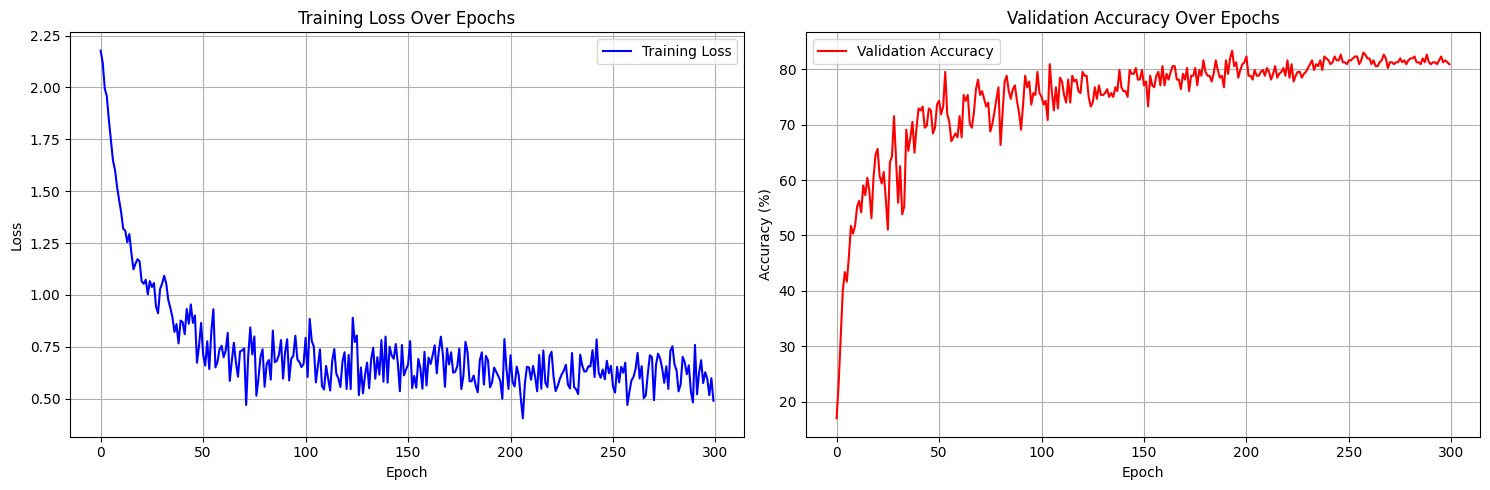


Final Results:
Best Validation Accuracy: 83.33%
Final Training Loss: 0.4895


In [11]:
# Plot training loss and validation accuracy
plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, 'r-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Results:")
print(f"Best Validation Accuracy: {max(test_accuracies):.2f}%")
print(f"Final Training Loss: {train_losses[-1]:.4f}")

## Confusion Matrix

The confusion matrix shows:
- Rows: True emotions
- Columns: Predicted emotions
- Numbers: Count of predictions
- Diagonal: Correct predictions
- Off-diagonal: Misclassifications

This helps identify which emotions are commonly confused with each other.

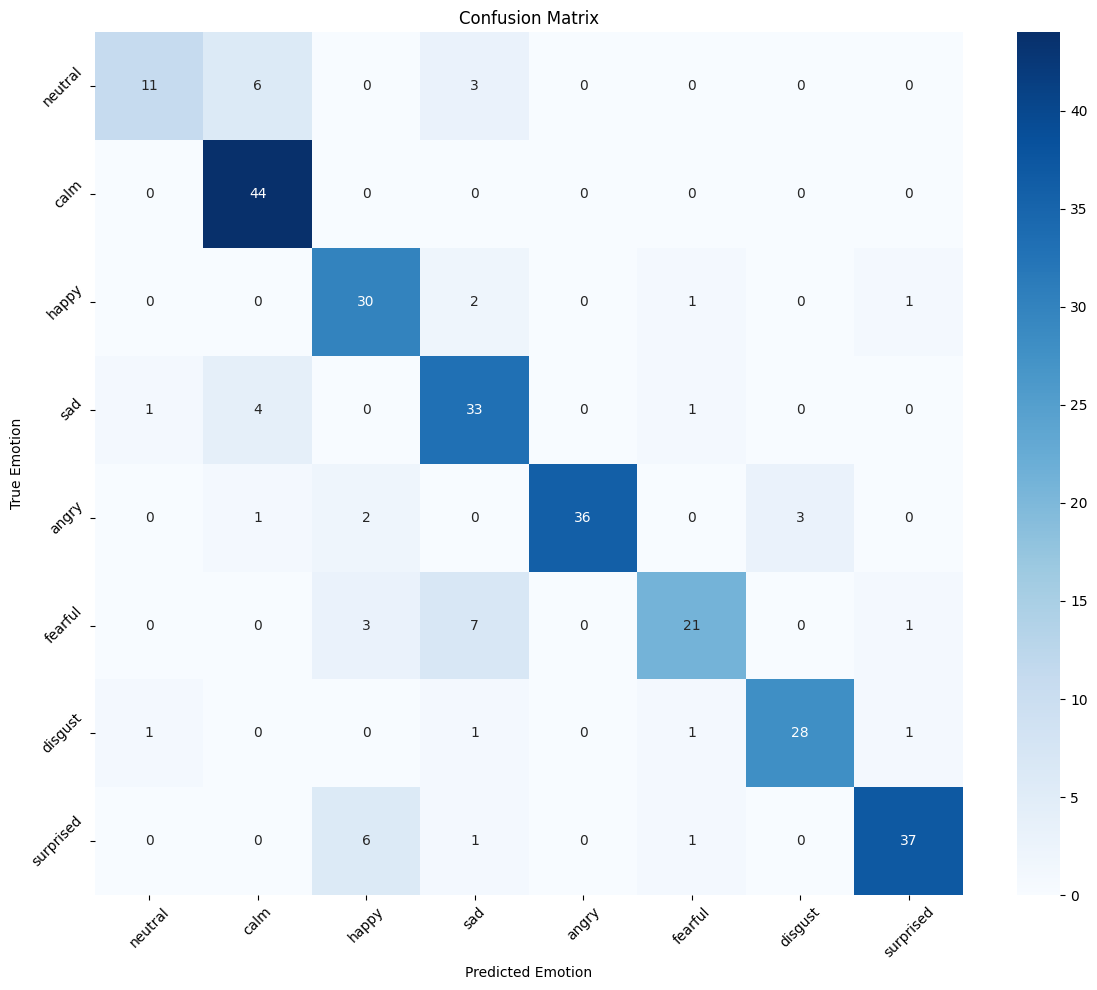


Confusion Matrix Analysis:
Total Correct Predictions: 240
Total Samples: 288
Overall Accuracy: 83.33%

Per-class Accuracy:
neutral: 55.00%
calm: 100.00%
happy: 88.24%
sad: 84.62%
angry: 85.71%
fearful: 65.62%
disgust: 87.50%
surprised: 82.22%


In [9]:
# Create and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(epoch_targets, epoch_predictions)

# Create confusion matrix plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Print overall metrics
total_correct = np.sum(np.diag(cm))
total_samples = np.sum(cm)
print(f"\nConfusion Matrix Analysis:")
print(f"Total Correct Predictions: {total_correct}")
print(f"Total Samples: {total_samples}")
print(f"Overall Accuracy: {100 * total_correct / total_samples:.2f}%")

# Calculate per-class accuracy
print("\nPer-class Accuracy:")
for i, emotion in enumerate(emotion_labels):
    class_correct = cm[i, i]
    class_total = np.sum(cm[i, :])
    if class_total > 0:
        class_accuracy = 100 * class_correct / class_total
        print(f"{emotion}: {class_accuracy:.2f}%")